# Training

In [32]:
#Import relevant packages
import sys
import os
import time
import pickle 
import numpy as np
import pandas as pd
import seaborn as sns #for plotting multi-graphs
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score

#models
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#import tensorflow as tf
#from tensorflow.keras import layers, models
from sklearn.naive_bayes import GaussianNB

#All command lines can be output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#active google drive
''' Uncomment it if you use google drive
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi
'''

" Uncomment it if you use google drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n!nvidia-smi\n"

## Data processing

In [33]:
#Read training data
source_path = "5. Binary Classification with a Bank Churn Dataset/train.csv"
df = pd.read_csv(source_path)

#Mapping gender and geography to numeric values
df_process = df
df_process['Gender'].replace({'Male': 0, 'Female': 1},inplace=True)
df_process['Geography'].replace({'France': 0, 'Germany': 1,'Spain':2},inplace=True)

#Check class record distribution in each classes, and remove customerId and Surname columns
class_data = df_process.drop(columns=['CustomerId', 'Surname']).groupby("Exited")

### Step 1 for validate accuracy 

In [34]:
#Step 1
df_phase_1 = df_process.drop(columns=['CustomerId', 'Surname'])

In [35]:
#Asssume normal distribution range of 99.73% is in [mean - 3 * std, mean + 3 * std] to remove outliers
def normal_distribution_outlier_remove(group_data):
    #record the orginal number of group records
    records_count = group_data.shape[0]
    
    for col in group_data.columns[1:-1]: #skip the id and last Exited column
        #store the mean and std of each column
        mean = group_data[col].mean()
        std = group_data[col].std()
        #Update the column values which locate in 99.73% that follows normal distribution
        group_data.loc[:,col] = group_data[col].where(((group_data[col])>=(mean - 3*std))
                  & ((group_data[col])<=(mean + 3*std)))

    #record the numbers of outliers
    records_count = records_count - group_data.dropna().shape[0]
    #print the number of outliers dropped
    print(str(records_count)+" outliers of class "+str(group_data["Exited"].iloc[0])+" removed.")
    
    return group_data.dropna()

In [36]:
#Separtate the data by classes
class_data_0 = class_data.get_group(0)
class_data_1 = class_data.get_group(1)

#Remove outliers of each classes
class_data_0_outlier_remove = normal_distribution_outlier_remove(class_data_0.copy())
class_data_1_outlier_remove = normal_distribution_outlier_remove(class_data_1.copy())

#Concat the class data
df_process = pd.concat([class_data_0_outlier_remove,class_data_1_outlier_remove]).sort_values(['id'])

2604 outliers of class 0 removed.
541 outliers of class 1 removed.


### Step 2 for validate accuracy

In [37]:
#step 2
df_phase_2 = df_process

In [38]:
#standardization
z_scaler = preprocessing.StandardScaler()
df_z = z_scaler.fit_transform(df_process.drop(columns=['id','Exited']))
df_z = pd.DataFrame(df_z)

#normalization
minmax_scaler = preprocessing.MinMaxScaler().fit(df_z)
df_norm = minmax_scaler.transform(df_z)

#Convert to dataframe
df_processed = pd.DataFrame(df_norm)
column_labels = ["CreditScore","Geography","Gender","Age","Tenure","Balance",
                "NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]
df_processed.columns = column_labels
df_processed.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.585421,0.0,0.0,0.288462,0.3,0.00000,0.5,1.0,0.0,0.907279
1,0.492027,0.0,0.0,0.288462,0.1,0.00000,0.5,1.0,1.0,0.247483
2,0.608200,0.0,0.0,0.423077,1.0,0.00000,0.5,1.0,0.0,0.924364
3,0.387244,0.0,0.0,0.307692,0.2,0.62454,0.0,1.0,1.0,0.422787
4,0.694761,1.0,0.0,0.288462,0.5,0.00000,0.5,1.0,1.0,0.075293


### Step 3 for validate accuracy

In [39]:
#step 3
df_phase_3 = df_processed

## Feature Selection

In [40]:
# Extract important features based on xgb
model_featureSelection_xgb = xgb.XGBClassifier().fit(df_processed,df_process['Exited'].values)
# Obtain the importance scores
feature_importance = model_featureSelection_xgb.feature_importances_
# Rank the importances
sorted_idx = np.argsort(feature_importance)[::-1]
print("Feature importance ranking:")
for i, idx in enumerate(sorted_idx):
    feature_name = column_labels[idx]  # If the identity matrix is a DataFrame，get feature name via col name
    print(f"{i + 1}. {feature_name}: {feature_importance[idx]}")


Feature importance ranking:
1. NumOfProducts: 0.5645909905433655
2. IsActiveMember: 0.14839358627796173
3. Age: 0.13351306319236755
4. Geography: 0.04921931028366089
5. Gender: 0.0463445745408535
6. Balance: 0.02249956876039505
7. HasCrCard: 0.011258451268076897
8. CreditScore: 0.008482641540467739
9. EstimatedSalary: 0.007966285571455956
10. Tenure: 0.007731486577540636


### Importance selection threshold >= 2%

## Model training and evaluation

In [41]:
#Split into training and validation set
#Stratified k-Fold Cross Validation
#Not balance Postive and Negative samples, use this to ensure the ratio
#Remove attributes with less importance towards attribute Exited
X=df_processed.drop(columns=['Tenure','HasCrCard','EstimatedSalary','CreditScore']).values
y=df_process['Exited'].values
#Select K=10
#skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
#skf_dnn = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
#Select K=5
skf = StratifiedKFold(n_splits=10,shuffle=True)

### Step 4 for validate accuarcy

In [42]:
#step 4
df_phase_4 = df_processed.drop(columns=['Tenure','HasCrCard','EstimatedSalary','CreditScore'])

### corresponding y

In [43]:
#Before removing outliers
y_phase_1 = df_phase_1['Exited'].values
#after removing outliers
y=df_process['Exited'].values

### Only use train test split function for phase 1-4

### Trained on CPU i9-14900K at 5.3GHz, Memory 64GB 3600MHz.

### Phase 5 + Phase 6

In [61]:
# train_model 
def train_model(model_name,X_train,y_train,class_weight):
    if class_weight =='balance':
       # sample balance 
         # fit the data into model
        if model_name == "LogisticRegression":
            model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "SupportVectorClassification":
            model = SVC(class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "KMeans":
            #kmeans not support class balance
            model = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(X_train)
            
        elif model_name == "DNN":
            '''
            skl_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
            class_weight = {0: skl_weight[0], 1: skl_weight[1]}
            model = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            layers.Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,class_weight=class_weight)
            '''
            
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "DecisionTreeClassifier":
            model = DecisionTreeClassifier(random_state=42,class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "XGBoost":
            scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
            model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight).fit(X_train, y_train)
        elif model_name == "NaiveBayes":
            #Bayes not support class balance
            model = GaussianNB().fit(X_train, y_train)
    else:
       # non balance sample weight
         # fit the data into model
        if model_name == "LogisticRegression":
            model = LogisticRegression().fit(X_train, y_train)
            
        elif model_name == "SupportVectorClassification":
            model = SVC().fit(X_train, y_train)
            
        elif model_name == "KMeans":
            model = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(X_train)
            
        elif model_name == "DNN":
            '''
            model = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            layers.Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)
            '''
            
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
            
        elif model_name == "DecisionTreeClassifier":
            model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
            
        elif model_name == "XGBoost":
            model = xgb.XGBClassifier().fit(X_train, y_train)
        elif model_name == "NaiveBayes":
            model = GaussianNB().fit(X_train, y_train)
    
    return model
    
    

In [62]:
# save_model
def save_model(model_name,model,phase):
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # file name
    filename = f"models/{model_name}_{phase}.pkl"
    
    # save the model
    with open(filename,'wb') as file:
        pickle.dump(model,file)
    
    print(f"Model saved as {filename}")
    

In [63]:
def model_phase_evaluation(model_name):
    # Phases set for 1 - 4
    phases = {
        "phase_1": df_phase_1.drop(columns=['Exited']),
        "phase_2": df_phase_2.drop(columns=['Exited']),
        "phase_3": df_phase_3,
        "phase_4": df_phase_4
    }

    results = []

    # Phase 1 - 4
    for phase in phases:
        # Phase 1 case
        if phase == "phase_1":
            X_train, X_test, y_train, y_test = train_test_split(phases[phase], y_phase_1, test_size=0.2, random_state=42)
        # Phase 2 - 4 case
        else:
            X_train, X_test, y_train, y_test = train_test_split(phases[phase], y, test_size=0.2, random_state=42)
        # Train the models
        start_time = time.time()
        model = train_model(model_name, X_train, y_train,class_weight='default')
        end_time = time.time()

        # save the models
        save_model(model_name, model, phase)

        # record training time
        training_time = end_time - start_time

        # Predict and evaluate roc_auc, accuracy, recall
        y_pred = model.predict(X_test)
        if model_name=="DNN":
                y_pred = (y_pred > 0.5).astype(int)
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # save the results
        results.append({
            "model name": model_name,
            "phase": phase,
            "training_time": training_time,
            "roc_auc": roc_auc,
            "accuracy": accuracy,
            "recall": recall
        })

    # Phase 5 - 6
    # use SKF

    phases_skf = {
        "phase_5": df_phase_4,
        "phase_6": df_phase_4
    }



    for phase in phases_skf:

        model_Best = None
        macro_f1_Best = 0.0
        micro_f1_Best = 0.0
        training_time_total = 0.0
        StratiedKFold = 0
        num_folds = 0
        y_test_Best = []
        y_pred_Best = []


        skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
        for train_index, test_index in skf.split(df_phase_4, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train the model
            start_time = time.time()
            if phase == 'phase_5':
                model = train_model(model_name,X_train, y_train,class_weight='default')
            elif phase == 'phase_6':
                model = train_model(model_name,X_train, y_train,class_weight='balance')
            end_time = time.time()

            # calculate training time
            training_time = end_time - start_time

            # put test data to predict
            y_pred = model.predict(X_test)
            if model_name=="DNN":
                y_pred = (y_pred > 0.5).astype(int)
            # validation 
            micro_f1 = f1_score(y_test,y_pred,average='micro')
            macro_f1 = f1_score(y_test,y_pred,average='macro')

            # Update best model with evaluation results
            if macro_f1 > macro_f1_Best:
                macro_f1_Best = macro_f1
                micro_f1_Best = micro_f1
                model_Best = model
                y_test_Best = y_test
                y_pred_Best = y_pred
                StratiedKFold = i+1

            # Sum total training time
            training_time_total += training_time
            num_folds += 1

        training_time = training_time_total / num_folds

        # save the model
        save_model(model_name, model_Best, phase)
        # Predict and evaluate roc_auc, accuracy, recall
        y_pred = model.predict(X_test)
        if model_name=="DNN":
                y_pred = (y_pred > 0.5).astype(int)
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # save the results
        results.append({
            "model name": model_name,
            "phase": phase,
            "training_time": training_time,
            "roc_auc": roc_auc,
            "accuracy": accuracy,
            "recall": recall
        })


    # Obtain the results
    model_names = [result["model name"] for result in results]
    phases = [result["phase"] for result in results]
    roc_aucs = [result["roc_auc"] for result in results]
    accuracies = [result["accuracy"] for result in results]
    recalls = [result["recall"] for result in results]
    training_times = [result["training_time"] for result in results]

    # plot the model performance
    plt.figure(figsize=(10, 6))
    plt.plot(phases, roc_aucs, marker='o', label='ROC/AUC')
    plt.plot(phases, accuracies, marker='o', label='Accuracy')
    plt.plot(phases, recalls, marker='o', label='Recall')
    
    plt.xlabel('Phase')
    plt.ylabel('Metrics')
    plt.title(f"{model_name} Performance at Each Phase")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(phases, training_times, marker='o', label='Training time')
    plt.xlabel('Phase')
    plt.ylabel('Training time (Seconds)')
    plt.title(f"{model_name} training time at Each Phase")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results


Model saved as models/LogisticRegression_phase_1.pkl
Model saved as models/LogisticRegression_phase_2.pkl
Model saved as models/LogisticRegression_phase_3.pkl
Model saved as models/LogisticRegression_phase_4.pkl
Model saved as models/LogisticRegression_phase_5.pkl
Model saved as models/LogisticRegression_phase_6.pkl


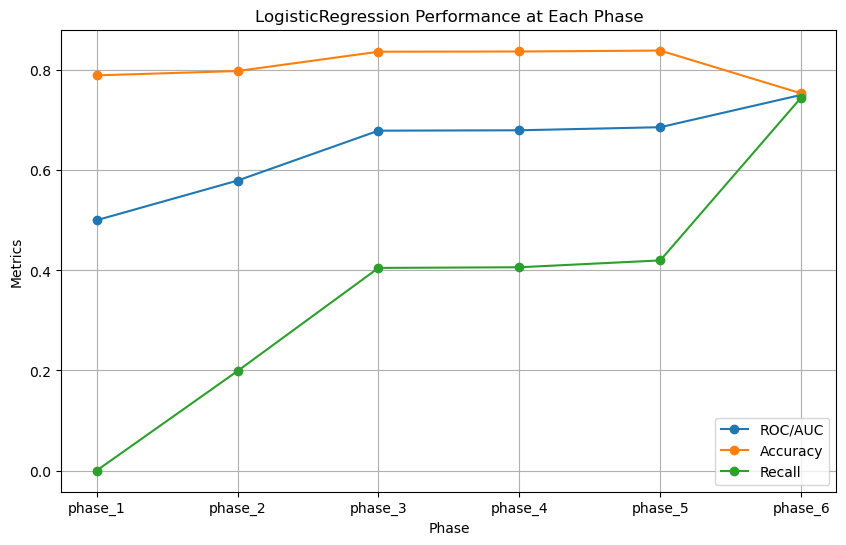

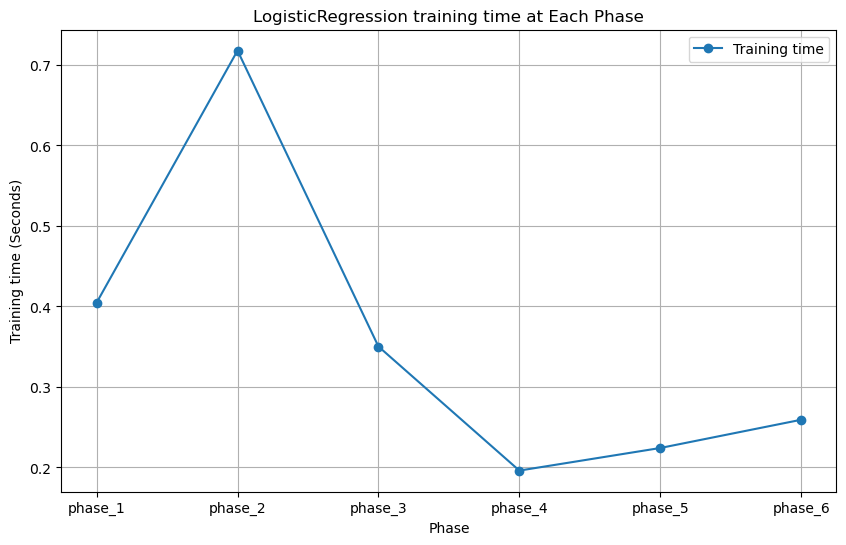

In [50]:
LogitisticRegression_phase_evaluation = model_phase_evaluation("LogisticRegression")

Model saved as models/KMeans_phase_1.pkl
Model saved as models/KMeans_phase_2.pkl
Model saved as models/KMeans_phase_3.pkl
Model saved as models/KMeans_phase_4.pkl
Model saved as models/KMeans_phase_5.pkl
Model saved as models/KMeans_phase_6.pkl


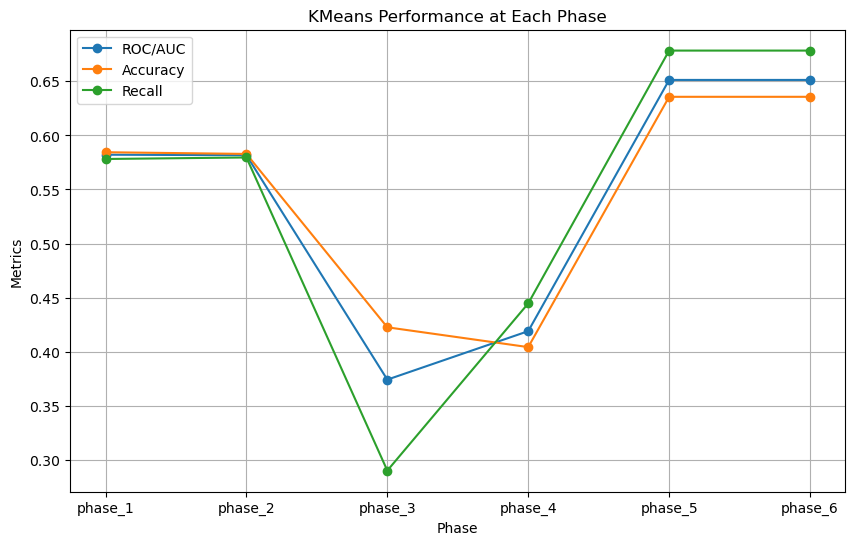

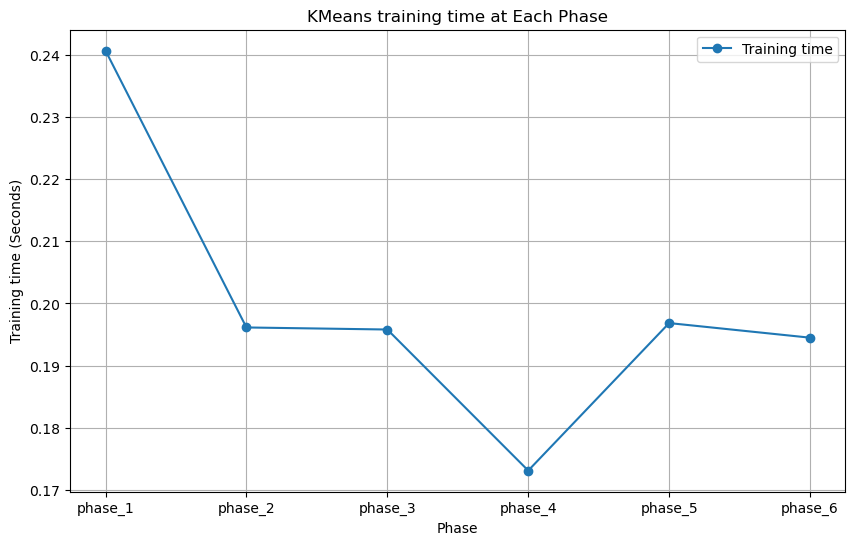

In [56]:
#KMeans
KMeans_phase_evaluation = model_phase_evaluation("KMeans")

Model saved as models/RandomForestClassifier_phase_1.pkl
Model saved as models/RandomForestClassifier_phase_2.pkl
Model saved as models/RandomForestClassifier_phase_3.pkl
Model saved as models/RandomForestClassifier_phase_4.pkl
Model saved as models/RandomForestClassifier_phase_5.pkl
Model saved as models/RandomForestClassifier_phase_6.pkl


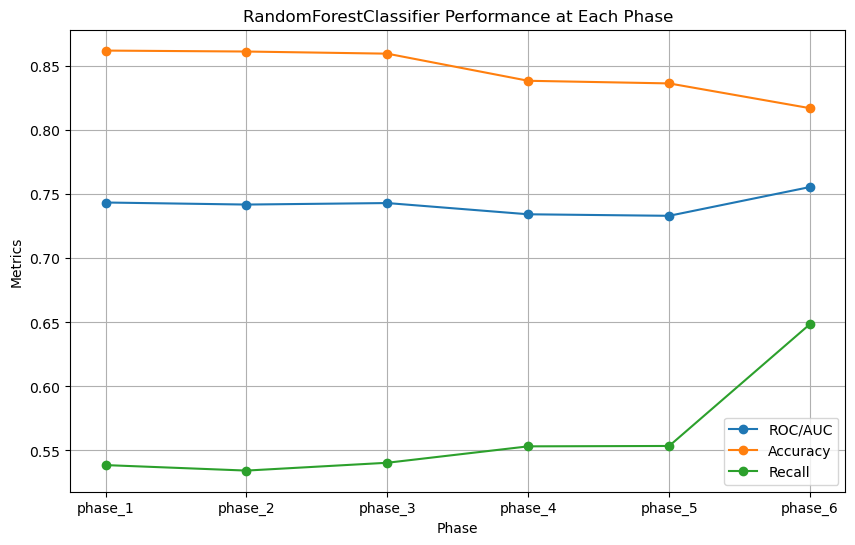

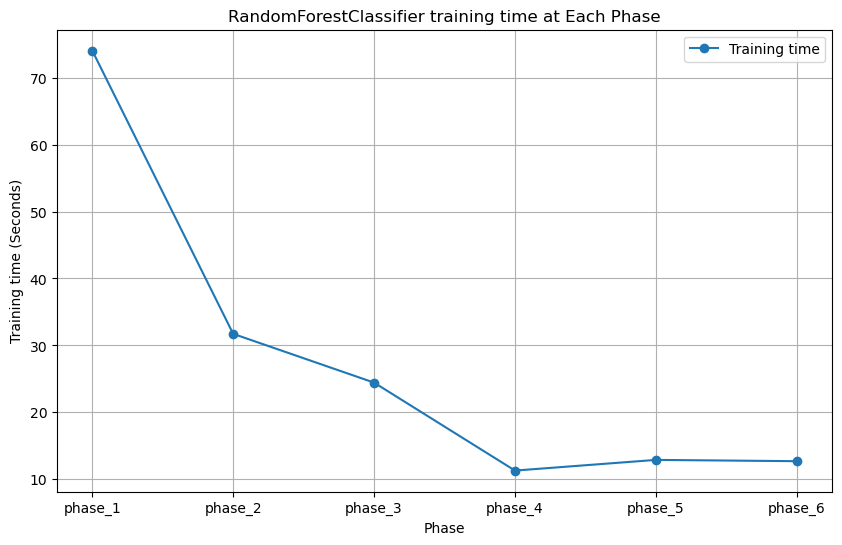

In [57]:
#RandomForestClassifier
RandomForestClassifier_phase_evaluation = model_phase_evaluation("RandomForestClassifier")

Model saved as models/DecisionTreeClassifier_phase_1.pkl
Model saved as models/DecisionTreeClassifier_phase_2.pkl
Model saved as models/DecisionTreeClassifier_phase_3.pkl
Model saved as models/DecisionTreeClassifier_phase_4.pkl
Model saved as models/DecisionTreeClassifier_phase_5.pkl
Model saved as models/DecisionTreeClassifier_phase_6.pkl


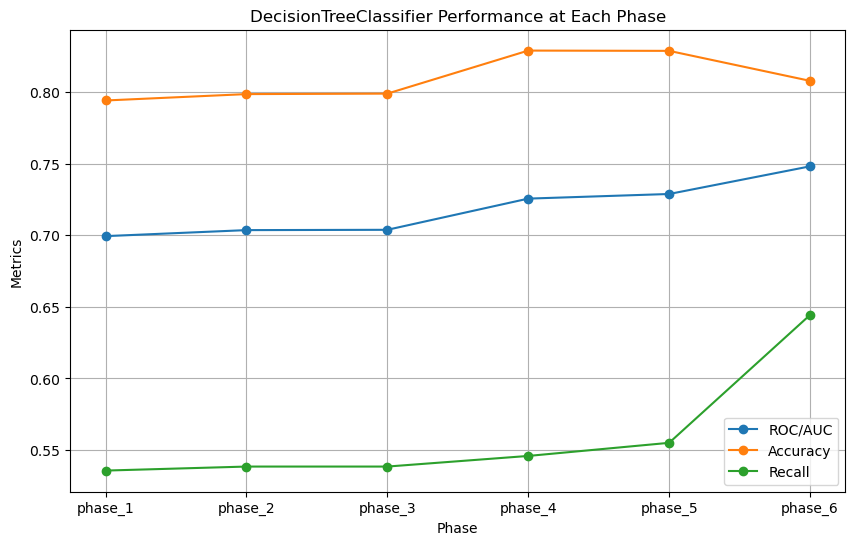

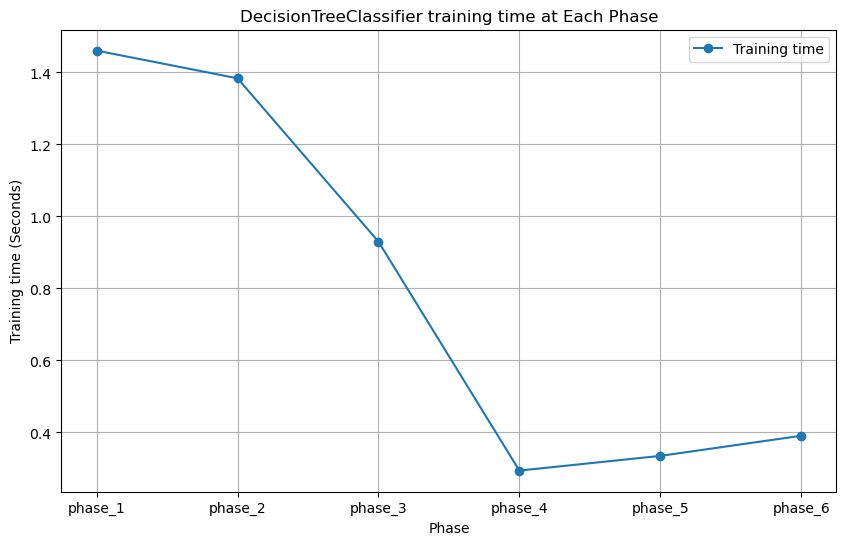

In [58]:
#DecisionTreeClassifier
DecisionTreeClassifier_phase_evaluation = model_phase_evaluation("DecisionTreeClassifier")

Model saved as models/XGBoost_phase_1.pkl
Model saved as models/XGBoost_phase_2.pkl
Model saved as models/XGBoost_phase_3.pkl
Model saved as models/XGBoost_phase_4.pkl
Model saved as models/XGBoost_phase_5.pkl
Model saved as models/XGBoost_phase_6.pkl


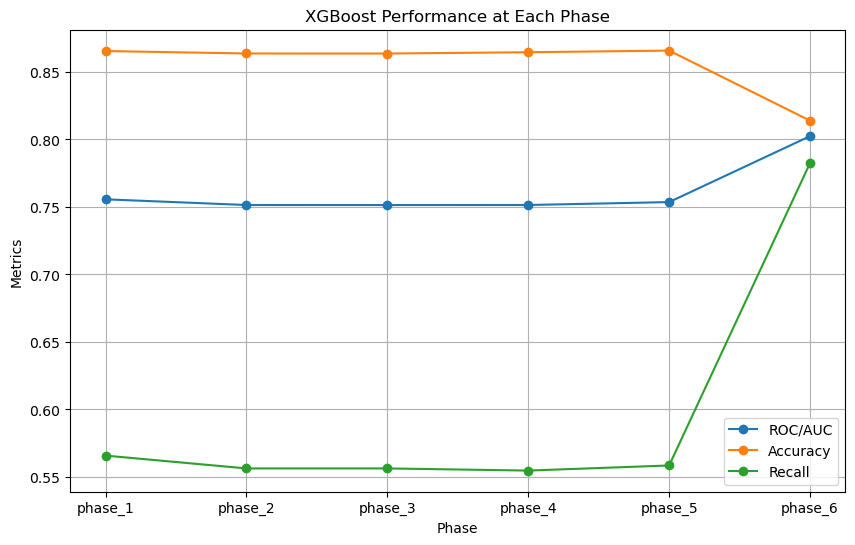

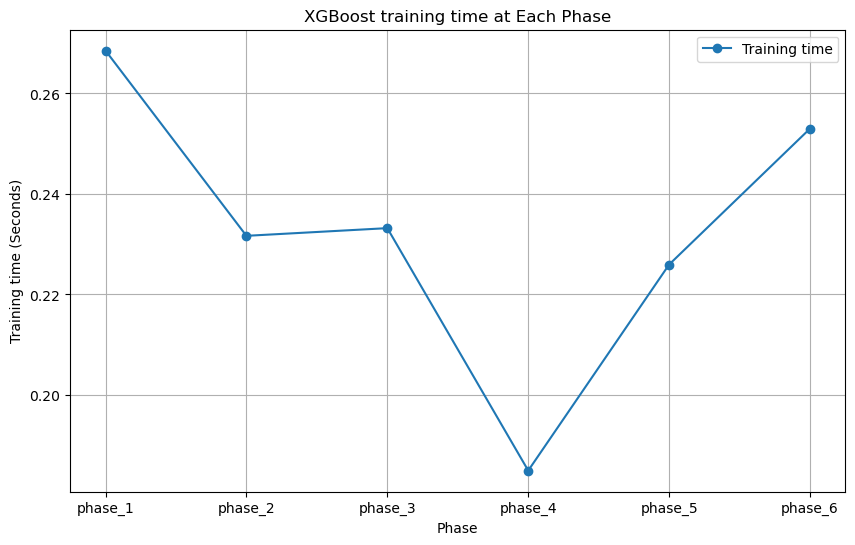

In [64]:
#XGBoost
XGBoost_phase_evaluation = model_phase_evaluation("XGBoost")

Model saved as models/NaiveBayes_phase_1.pkl
Model saved as models/NaiveBayes_phase_2.pkl
Model saved as models/NaiveBayes_phase_3.pkl
Model saved as models/NaiveBayes_phase_4.pkl
Model saved as models/NaiveBayes_phase_5.pkl
Model saved as models/NaiveBayes_phase_6.pkl


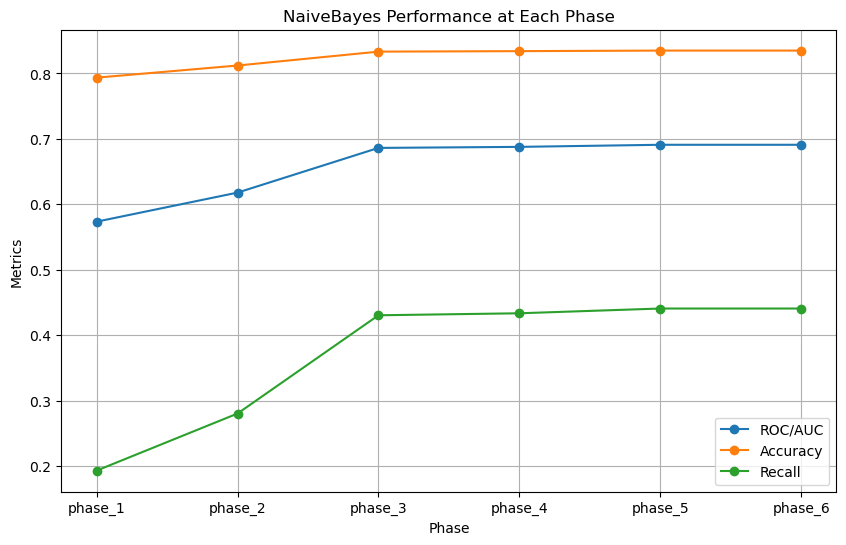

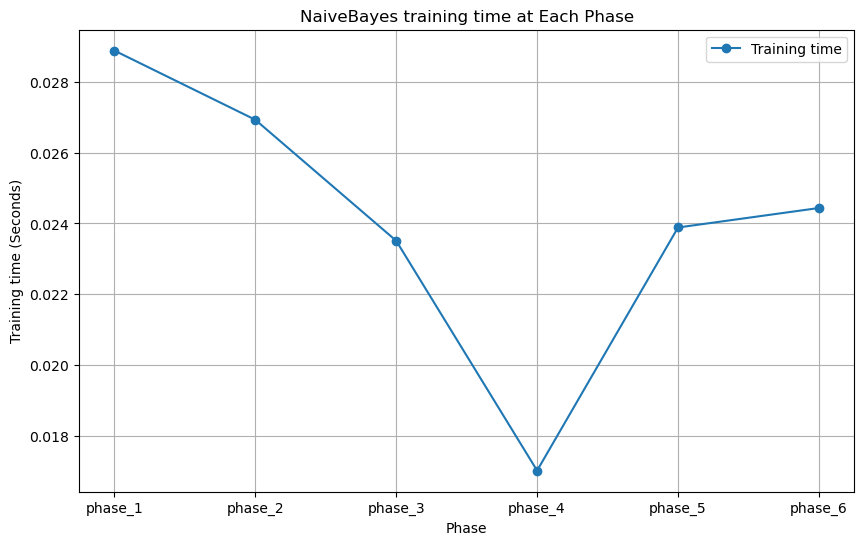

In [60]:
#NaiveBayes
NaiveBayes_phase_evaluation = model_phase_evaluation("NaiveBayes")

In [ ]:
#SupportVectorClassification
#SupportVectorClassification_phase_evaluation = model_phase_evaluation("SupportVectorClassification")

In [ ]:
#DNN
#DNN_phase_evaluation = model_phase_evaluation("DNN")

In [32]:
#Train and Evaluate template
def train_and_evaluate(model_name):
    model_Best = None
    macro_f1_Best = 0.0
    micro_f1_Best = 0.0
    training_time_total = 0.0
    StratiedKFold = 0
    num_folds = 0
    y_test_Best = []
    y_pred_Best = []
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        #print(f'StratifiedKFold {i+1}:')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Training Time start
        train_start = time.time()
        
        # fit the data into model
        if model_name == "LogisticRegression":
            model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "SupportVectorClassification":
            model = SVC(class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "KMeans":
            model = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(X_train)
            
        elif model_name == "DNN":
            '''
            skl_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
            class_weight = {0: skl_weight[0], 1: skl_weight[1]}
            model = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            layers.Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,class_weight=class_weight)
            '''
            
            
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "DecisionTreeClassifier":
            model = DecisionTreeClassifier(random_state=42,class_weight='balanced').fit(X_train, y_train)
            
        elif model_name == "XGBoost":
            scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
            model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight).fit(X_train, y_train)
        elif model_name == "NaiveBayes":
            model = GaussianNB().fit(X_train, y_train)
            
        # Training Time stop
        train_stop = time.time()
        training_time = train_stop-train_start
        #print(f"Training time: {training_time} s")
        
        # put test data to predict
        y_pred = model.predict(X_test)
        if model_name=="DNN":
            y_pred = (y_pred > 0.5).astype(int)
        # validation 
        micro_f1 = f1_score(y_test,y_pred,average='micro')
        macro_f1 = f1_score(y_test,y_pred,average='macro')
        #print('micro f1: ', micro_f1)
        #print('marco f1: ', macro_f1)
      
        # Update best model with evaluation results
        if macro_f1 > macro_f1_Best:
            macro_f1_Best = macro_f1
            micro_f1_Best = micro_f1
            model_Best = model
            y_test_Best = y_test
            y_pred_Best = y_pred
            StratiedKFold = i+1
        
        # Sum total training time
        training_time_total += training_time
        num_folds += 1
        if model_name =="DNN":
            break;

        #print('\n')

    
    print('Best model occurs at Stratied K Fold = ', StratiedKFold)
    
    # model size
    model_size = sys.getsizeof(model_Best)
    print(f"model size: {model_size} bytes")
        
    # Calculate average training time
    training_time_average = training_time_total / num_folds
    print(f"Average training time: {training_time_average} s \n")


    # Show Best F1 scores
    print('Best micro f1: ', micro_f1_Best)
    print('Best marco f1: ', macro_f1_Best,'\n')

    # Check class precision and recall 
    print("Classfication report on Exited = 0, 1")
    report = classification_report(y_test_Best, y_pred_Best)
    print(report)
 
    
    #Plot ROC curve
    display = RocCurveDisplay.from_predictions(
        y_test_Best,
        y_pred_Best,
        name=f"{model_name}",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Receiver Operating Characteristic (ROC) Curve of Model: {model_name}",
    )
    
    return model_Best


Best model occurs at Stratied K Fold =  1
model size: 48 bytes
Average training time: 0.07266316413879395 s 

Best micro f1:  0.7594663042806844
Best marco f1:  0.702203290579831 

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     12751
           1       0.46      0.76      0.57      3438

    accuracy                           0.76     16189
   macro avg       0.69      0.76      0.70     16189
weighted avg       0.82      0.76      0.78     16189



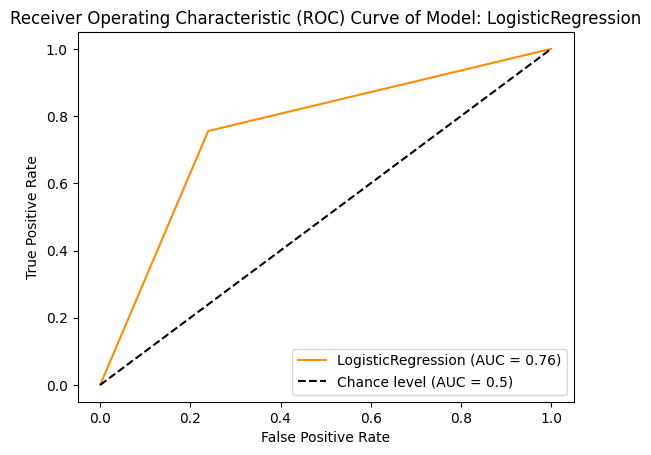

In [9]:
#Logistic Regression
model_LogisticRegression = train_and_evaluate("LogisticRegression")

Best model occurs at Stratied K Fold =  2
model size: 48 bytes
Average training time: 265.2747760057449 s 

Best micro f1:  0.8107356847241954
Best marco f1:  0.7564880781844412 

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     12751
           1       0.54      0.80      0.64      3438

    accuracy                           0.81     16189
   macro avg       0.74      0.81      0.76     16189
weighted avg       0.85      0.81      0.82     16189



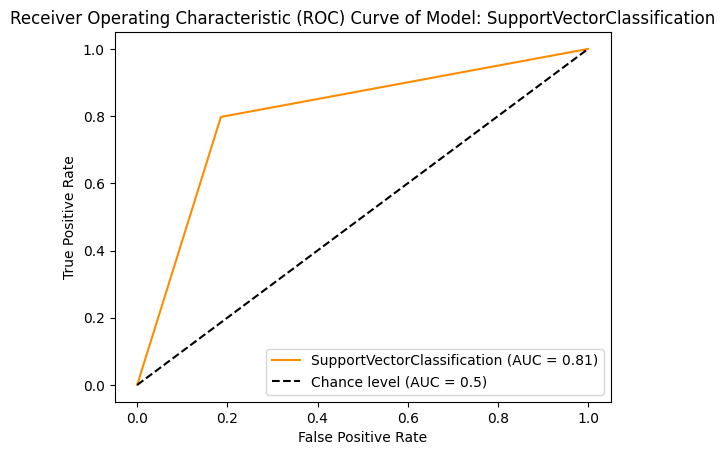

In [10]:
#SVM Classifier
model_svmClassfier = train_and_evaluate("SupportVectorClassification")

Best model occurs at Stratied K Fold =  2
model size: 48 bytes
Average training time: 0.2855722904205322 s 

Best micro f1:  0.8150596083760578
Best marco f1:  0.7407568739251035 

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     12751
           1       0.55      0.66      0.60      3438

    accuracy                           0.82     16189
   macro avg       0.73      0.76      0.74     16189
weighted avg       0.83      0.82      0.82     16189



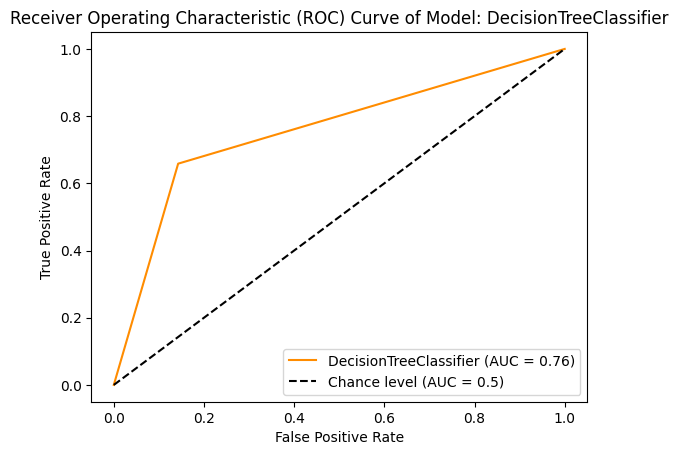

In [13]:
#Decision tree
model_DecisionTreeClassifier = train_and_evaluate("DecisionTreeClassifier")

Best model occurs at Stratied K Fold =  2
model size: 48 bytes
Average training time: 9.151743268966674 s 

Best micro f1:  0.8251899437889926
Best marco f1:  0.7498861095538962 

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.90      0.87      0.89     12751
           1       0.58      0.65      0.61      3438

    accuracy                           0.83     16189
   macro avg       0.74      0.76      0.75     16189
weighted avg       0.83      0.83      0.83     16189



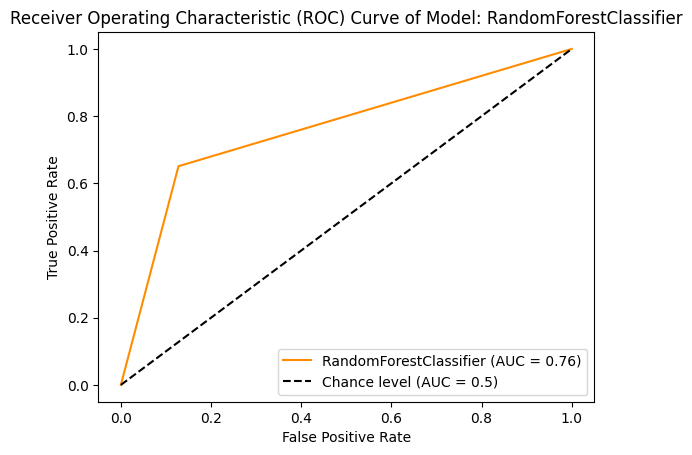

In [14]:
#Random Forest
model_RandomForestClassifier = train_and_evaluate("RandomForestClassifier")

Best model occurs at Stratied K Fold =  6
model size: 56 bytes
Average training time: 0.20738544464111328 s 

Best micro f1:  0.8196923837173389
Best marco f1:  0.7641912818617493 

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     12751
           1       0.55      0.79      0.65      3438

    accuracy                           0.82     16189
   macro avg       0.74      0.81      0.76     16189
weighted avg       0.85      0.82      0.83     16189



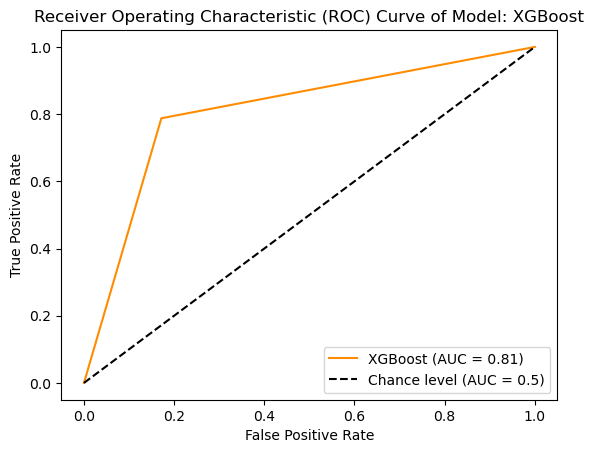

In [33]:
#XGBoost
model_XGBoost = train_and_evaluate("XGBoost")

C:\Users\huang\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\huang\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Best model occurs at Stratied K Fold =  2
model size: 56 bytes
Average training time: 0.13244357109069824 s 

Best micro f1:  0.5957131385508678
Best marco f1:  0.5389819889843341 

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.84      0.60      0.70     25502
           1       0.28      0.58      0.38      6876

    accuracy                           0.60     32378
   macro avg       0.56      0.59      0.54     32378
weighted avg       0.72      0.60      0.63     32378



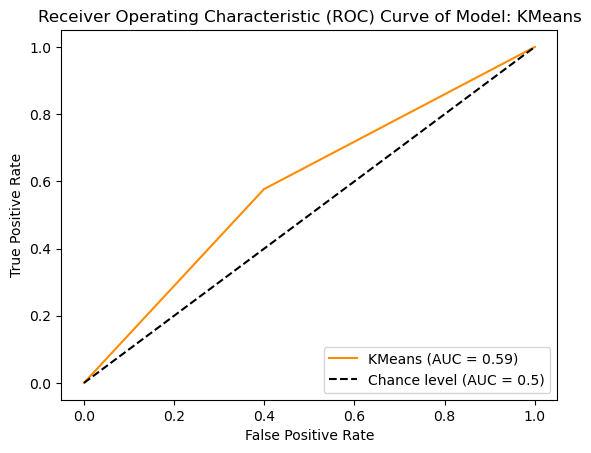

In [29]:
#K-means clustering
model_Kmeans = train_and_evaluate("KMeans")

Best model occurs at Stratied K Fold =  1
model size: 48 bytes
Average training time: 0.013448858261108398 s 

Best micro f1:  0.8392118104886034
Best marco f1:  0.7226131937682971 

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     12751
           1       0.69      0.45      0.54      3438

    accuracy                           0.84     16189
   macro avg       0.77      0.70      0.72     16189
weighted avg       0.83      0.84      0.83     16189



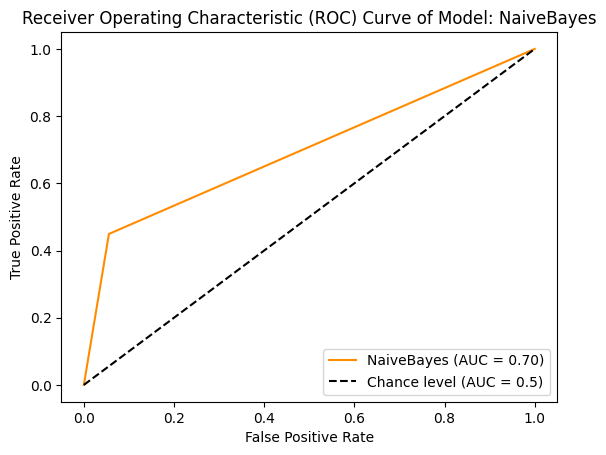

In [20]:
#NaiveBayes
model_NaiveBayes = train_and_evaluate("NaiveBayes")

Classfication report on Exited = 0, 1
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     25502
           1       0.57      0.20      0.29      6876

    accuracy                           0.80     32378
   macro avg       0.69      0.58      0.59     32378
weighted avg       0.76      0.80      0.76     32378



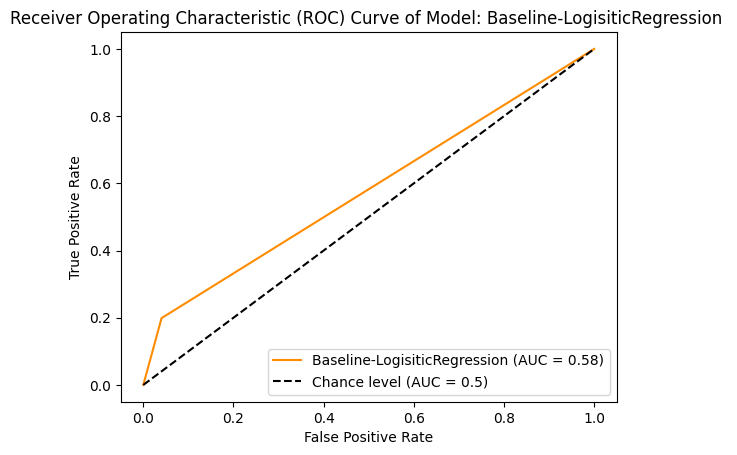

In [44]:
#Logistic Regression Baseline
X=df_process.drop(columns=['Exited']).values
y=df_process['Exited'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_baseline_LR = LogisticRegression().fit(X_train, y_train)
y_pred = model_baseline_LR.predict(X_test)
# Check class precision and recall 
print("Classfication report on Exited = 0, 1")
report = classification_report(y_test, y_pred)
print(report)
#Plot ROC curve
display = RocCurveDisplay.from_predictions(
    y_test,
    y_pred,
    name="Baseline-LogisiticRegression",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic (ROC) Curve of Model: Baseline-LogisiticRegression ",
)

Epoch 1/100
2530/2530 [==============================] - 1s 454us/step - loss: 224.7563 - accuracy: 0.5114
Epoch 2/100
2530/2530 [==============================] - 1s 454us/step - loss: 147.9520 - accuracy: 0.5243
Epoch 3/100
2530/2530 [==============================] - 1s 446us/step - loss: 130.4946 - accuracy: 0.5371
Epoch 4/100
2530/2530 [==============================] - 1s 449us/step - loss: 128.7422 - accuracy: 0.5455
Epoch 5/100
2530/2530 [==============================] - 1s 448us/step - loss: 109.5207 - accuracy: 0.5532
Epoch 6/100
2530/2530 [==============================] - 1s 443us/step - loss: 113.4195 - accuracy: 0.5595
Epoch 7/100
2530/2530 [==============================] - 1s 447us/step - loss: 108.9234 - accuracy: 0.5648
Epoch 8/100
2530/2530 [==============================] - 1s 458us/step - loss: 92.0337 - accuracy: 0.5751
Epoch 9/100
2530/2530 [==============================] - 1s 450us/step - loss: 100.6300 - accuracy: 0.5759
Epoch 10/100
2530/2530 [==============

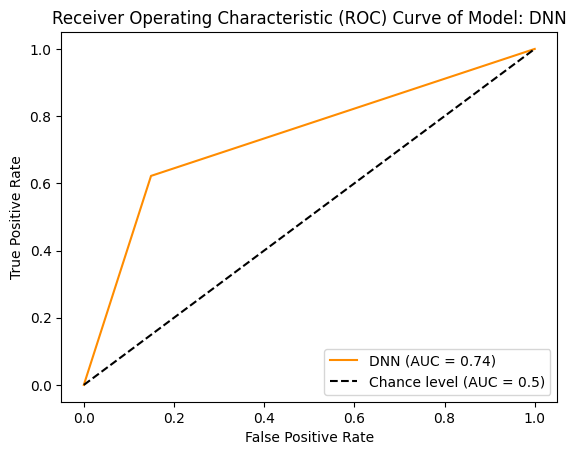

In [52]:
#Deep Neural Network
model_DNN = train_and_evaluate("DNN")

## Submission of predicting testset label

In [34]:
#Read test data
source_path = "5. Binary Classification with a Bank Churn Dataset/test.csv"
df_test = pd.read_csv(source_path)
df_test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [35]:
#Read test data
source_path = "5. Binary Classification with a Bank Churn Dataset/test.csv"
df_test = pd.read_csv(source_path)

#Mapping gender and geography to numeric values
df_process_test = df_test 
df_process_test['Gender'].replace({'Male': 0, 'Female': 1},inplace=True)
df_process_test['Geography'].replace({'France': 0, 'Germany': 1,'Spain':2},inplace=True)

#standardlization
df_z_test = z_scaler.transform(df_process_test.drop(columns=['id','CustomerId','Surname']))
#normalization
df_norm_test = minmax_scaler.transform(df_z_test)

#Convert to dataframe
df_processed_test = pd.DataFrame(df_norm_test)
df_processed_test.columns = column_labels
df_processed_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.398633,0.0,1.0,0.096154,0.2,0.000000,0.5,0.0,1.0,0.804903
1,0.619590,0.0,1.0,0.538462,0.2,0.000000,0.0,1.0,0.0,0.362723
2,0.558087,0.0,1.0,0.307692,0.7,0.000000,0.5,1.0,0.0,0.694419
3,0.615034,0.0,0.0,0.346154,0.8,0.000000,0.0,1.0,0.0,0.569654
4,0.776765,0.5,0.0,0.384615,1.0,0.508683,0.0,1.0,0.0,0.697164


In [37]:
#Predict labels
y_pred_test = model_XGBoost.predict(df_processed_test.drop(columns=['Tenure','HasCrCard','EstimatedSalary','CreditScore']))


In [38]:
#Output the result with CustomerID and Exited columns in csv format.
result_df = pd.DataFrame({'CustomerId': df_test['CustomerId'], 'Exited': y_pred_test})
result_df.to_csv('5. Binary Classification with a Bank Churn Dataset/submissions.csv', index=False)